In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor  # pip install scikit-learn

mpl.style.use("fivethirtyeight")
mpl.rcParams["figure.figsize"] = (15, 8)
mpl.rcParams["figure.dpi"] = 50
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25

In [86]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("../data/interim/01_data_resampled.pkl")

outlier_columns = df.columns[:6].to_list()
outlier_columns # All the columns except the label column

['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

#### IQR Criterion
<img src="../img/IQR.jpg">

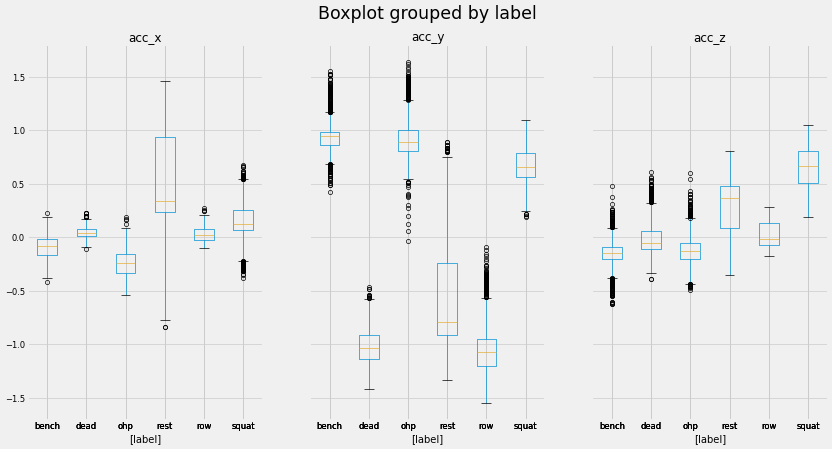

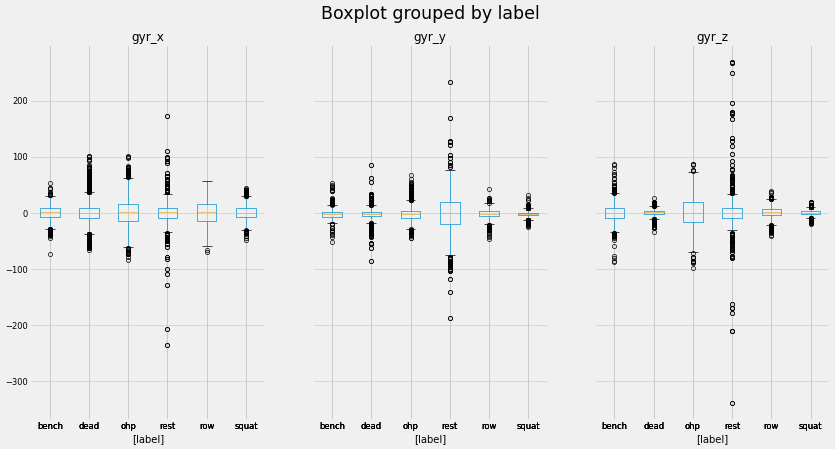

In [87]:
# --------------------------------------------------------------
# Plotting outliers
# --------------------------------------------------------------

# Creating a boxplot for a single column

# df[["acc_y", "label"]].boxplot(by="label", figsize=(20, 10))

# Ploting the acc
df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
# Ploting the gyr
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
plt.show()

In [88]:
# --------------------------------------------------------------
# Function to plot blue for not outliers and red for outliers
# --------------------------------------------------------------

def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """Plot outliers in case of a binary outlier score. Here, the col specifies the real
    data column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from:
    # https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["no outlier " + col, "outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [89]:
# --------------------------------------------------------------
# Interquartile range (distribution based)
# --------------------------------------------------------------

# Insert IQR function
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset


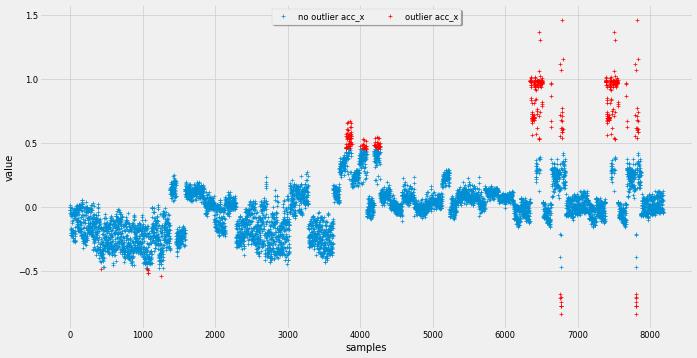

In [90]:
# Plot a single column to verify if the outliers are marked correctly
col = "acc_x"
dataset = mark_outliers_iqr(df, col)
plot_binary_outliers(dataset, col, col + "_outlier", True)

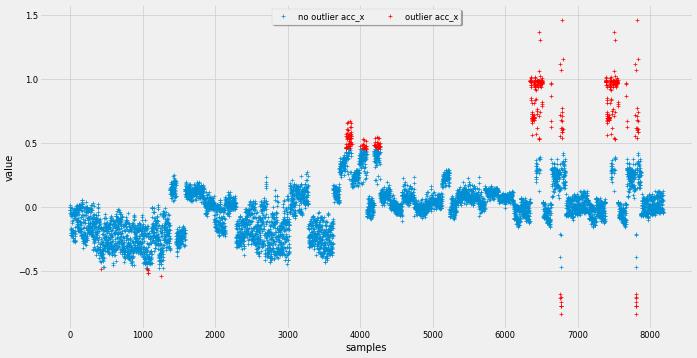

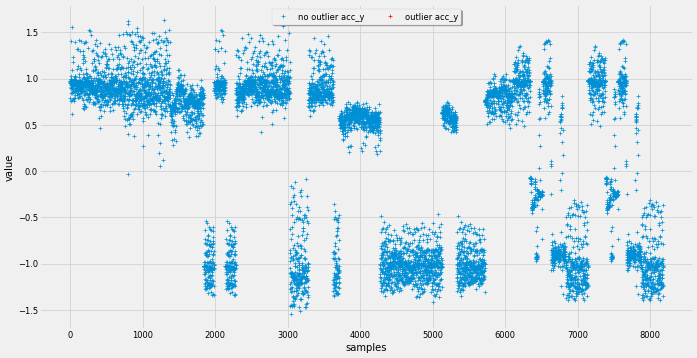

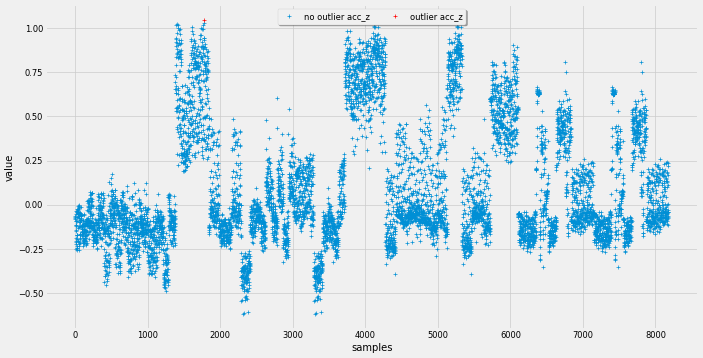

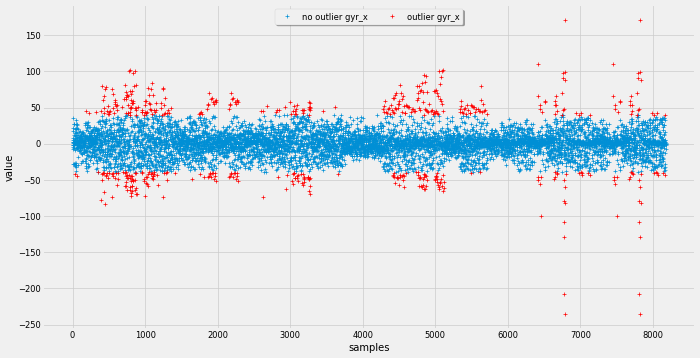

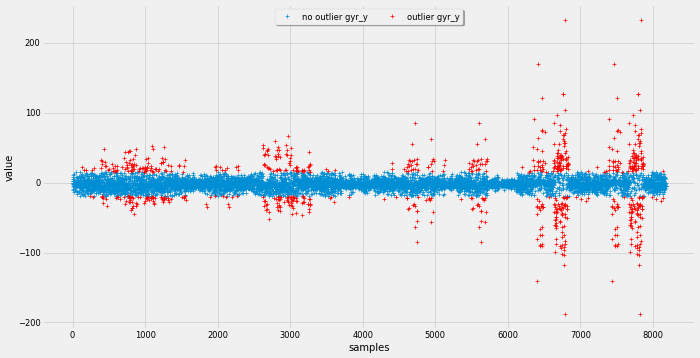

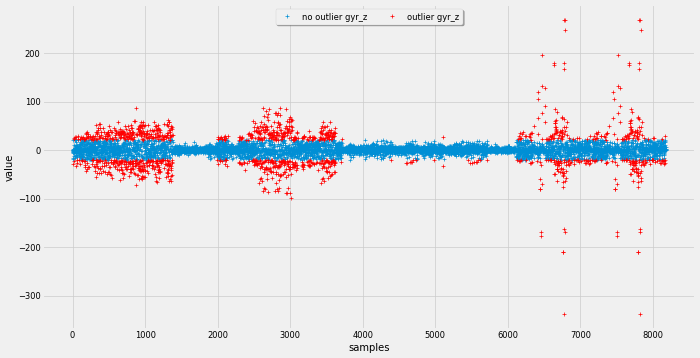

In [91]:
# Loop over all columns
for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(dataset, col, col + "_outlier", True)

#### **Chauvenet's Criterion**

- It's a method used to detect discrepant values ​​in a data set.
- A outlier is a data point that is significantly different from other data points in the data set.
Chauvenet's criterion is based on the assumption that the probability of an outlier occurs in a given data set is relatively low.
- This criterion is useful in situations where we want to identify discrepant values ​​in data that follow a normal distribution.
- This criterion involves rejecting a (outlier) measurement of a size `N` data set when its observation probability is less than `1/2N`.
- Value 2 in the formula can be replaced by a parameter `C` to generalize the criterion for different situations.

*Note:*
- If the data set is not distributed normally, Chauvenet criterion may not be suitable to identify discrepant values. This is because the method is based on the normal assumption to calculate the probability of each data point being an atypical value.
- The histogram show a bell-shaped curve? This indicates that the data is usually distributed.
- The box is symmetrical, this indicates that the data is normally distributed.

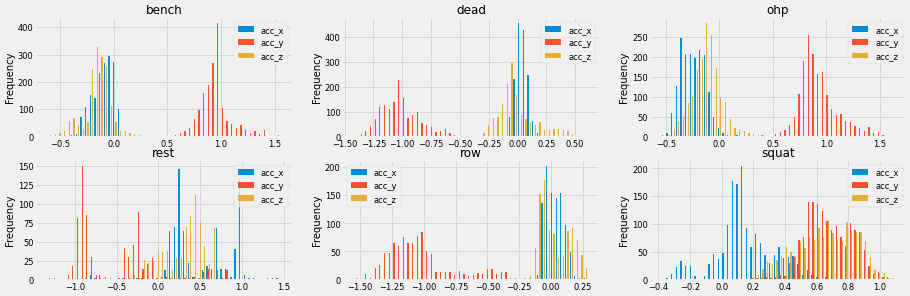

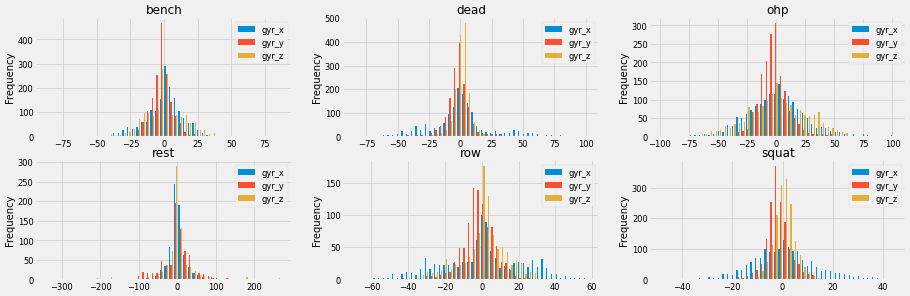

In [92]:
# --------------------------------------------------------------
# Chauvenets criteron (distribution based)
# --------------------------------------------------------------

# Check for normal distribution (must be normal distribui)
df[outlier_columns[:3] + ["label"]].plot.hist(
    bins=50, by="label", figsize=(20, 10), layout=(3, 3)
)
plt.title("Accelerometer")
df[outlier_columns[3:] + ["label"]].plot.hist(
    bins=50, by="label", figsize=(20, 10), layout=(3, 3)
)
plt.show()

In [93]:
# --------------------------------------------------------------
# Insert Chauvenet's function
# --------------------------------------------------------------

def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Taken from:
    https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

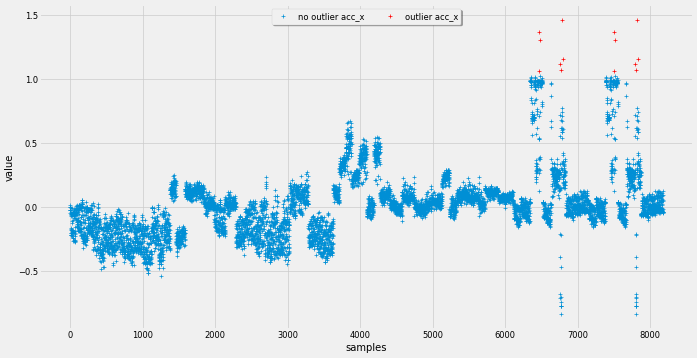

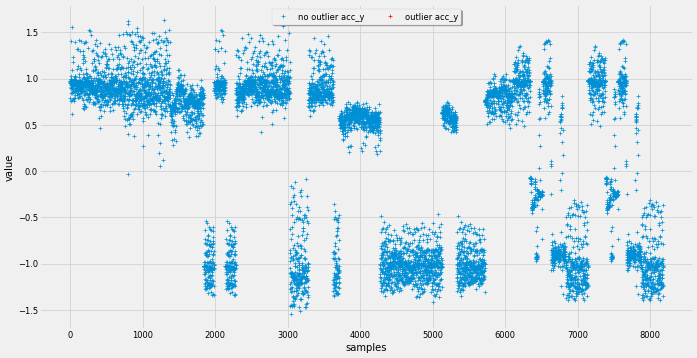

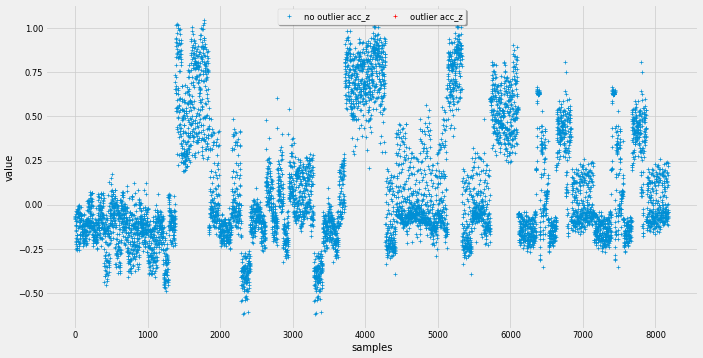

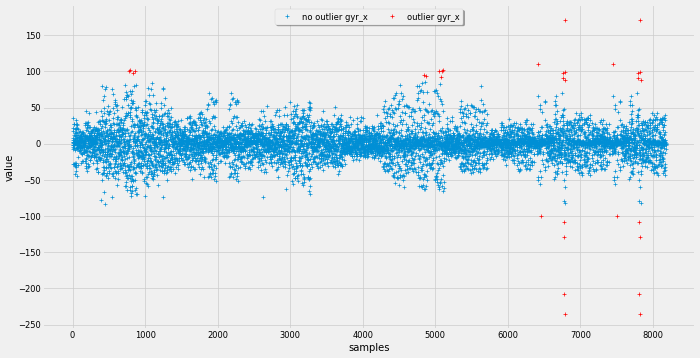

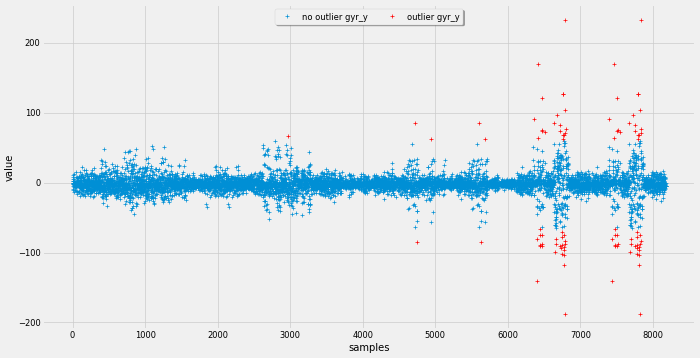

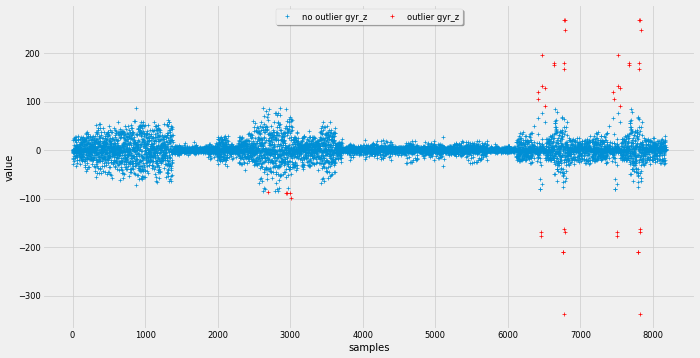

In [94]:
# Loop over all columns using chauvenet criterion
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(dataset, col, col + "_outlier", True)

#### Local Outlier Factor

- It is an unsupervised method, which means it does not require data labeled to identify outliers.
- LOF calculates local density deviation from a certain data point in relation to your neighbors. This means that it analyzes the density of the data points around a given point to determine if it is an atypical value.
- The algorithm considers samples that have a substantially smaller density than their neighbors as discrepant. This means that if a data point has few neighboring points, it is likely to be an outlier.
- The number of neighbors considered by the algorithm is controlled by a parameter called N_Neighbors. Normally, this parameter is defined as 1 more than the minimum number of samples that a grouping should contain, so that other samples can be discrepant local compared to this grouping and 2 smaller than the maximum number of nearby samples that may be local discrepant values.
- In practice, it is usually difficult to determine the minimum and maximum number of neighbors, so a value of n_vizinhos = 20 is commonly used.

<img src="../img/LOF.jpg">

In [95]:
# --------------------------------------------------------------
# Local outlier factor (distance based)
# --------------------------------------------------------------

# Insert LOF function
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

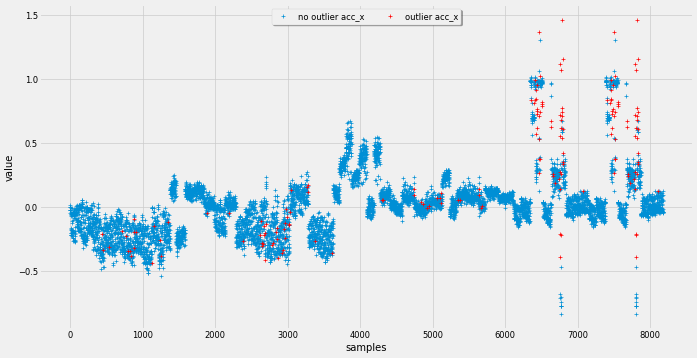

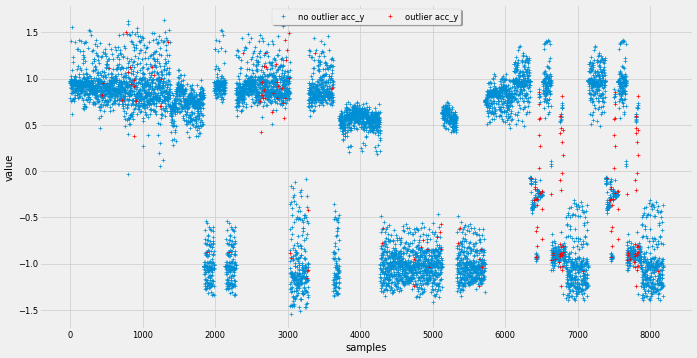

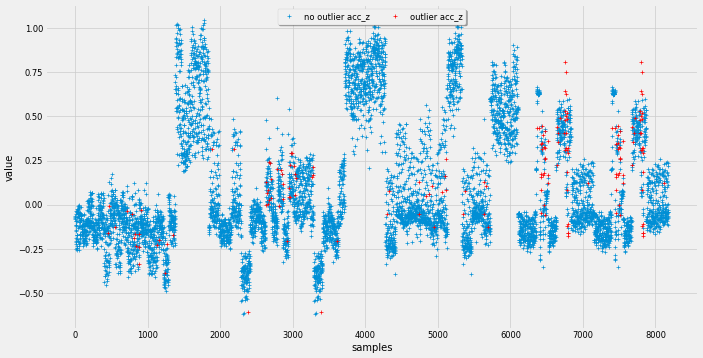

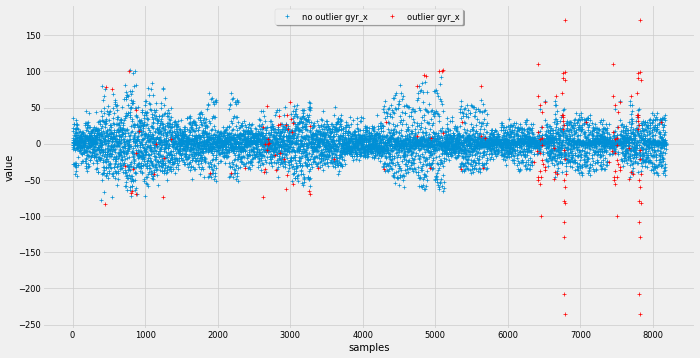

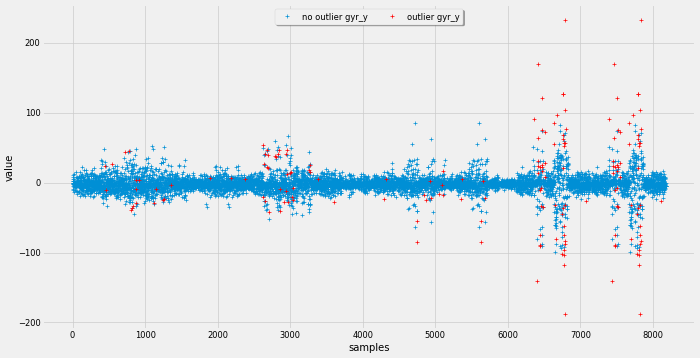

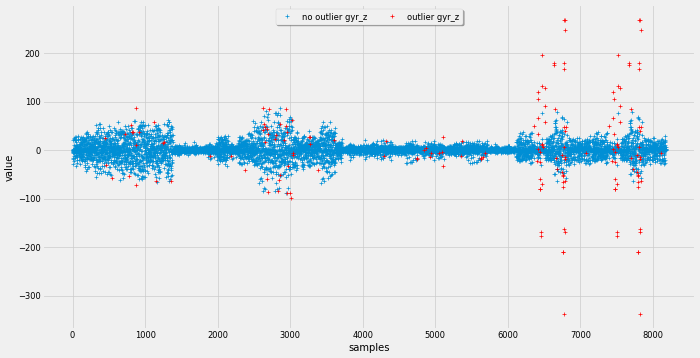

In [96]:
# Loop over all columns unsing LOF
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)

for col in outlier_columns:
    plot_binary_outliers(dataset, col, "outlier_lof", True)

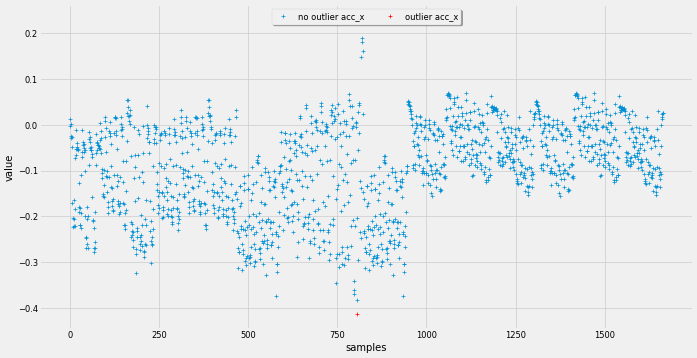

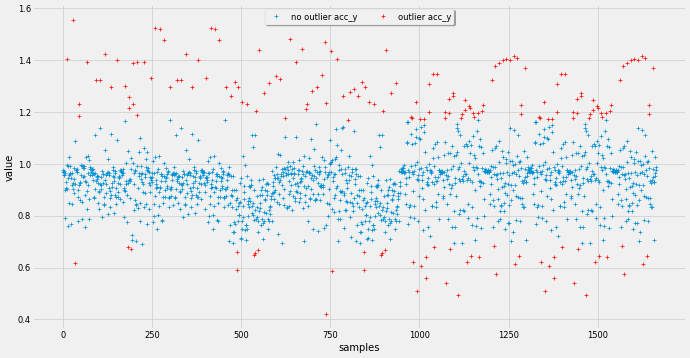

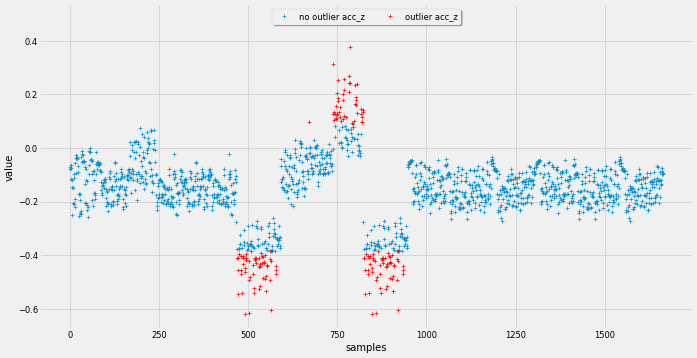

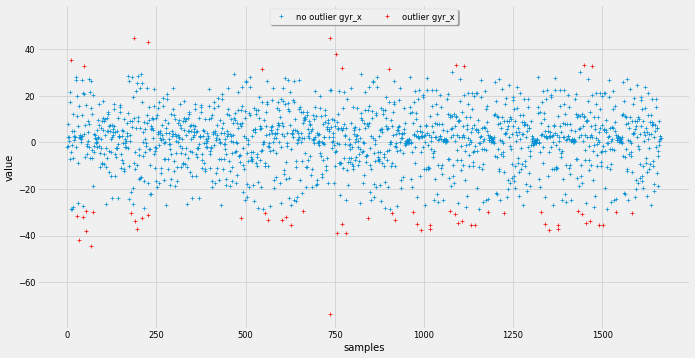

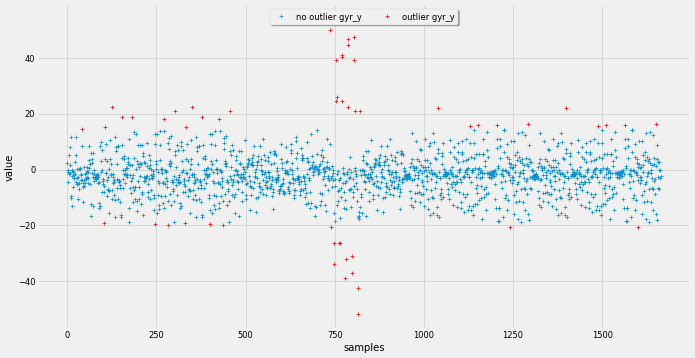

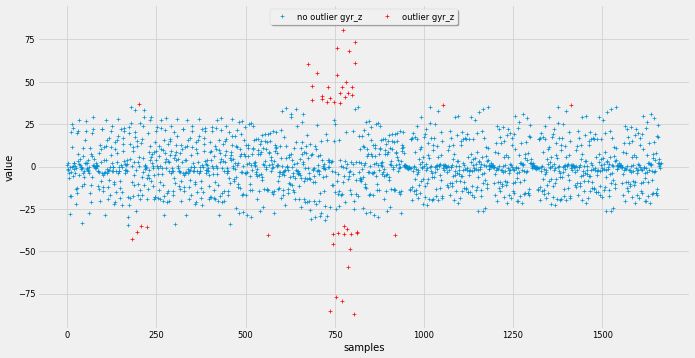

In [97]:
# --------------------------------------------------------------
# Check outliers grouped by label
# --------------------------------------------------------------

label = "bench"

# IQR
for col in outlier_columns:
    dataset = mark_outliers_iqr(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col + "_outlier", True)

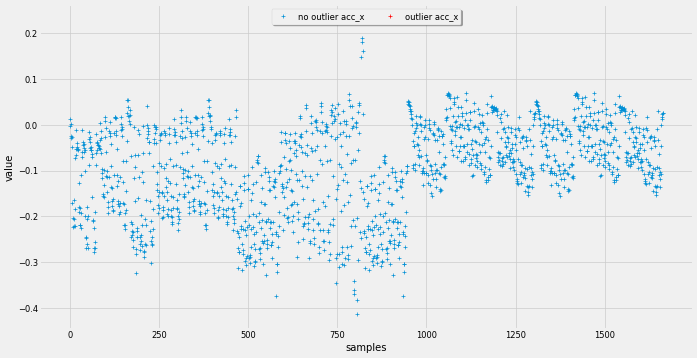

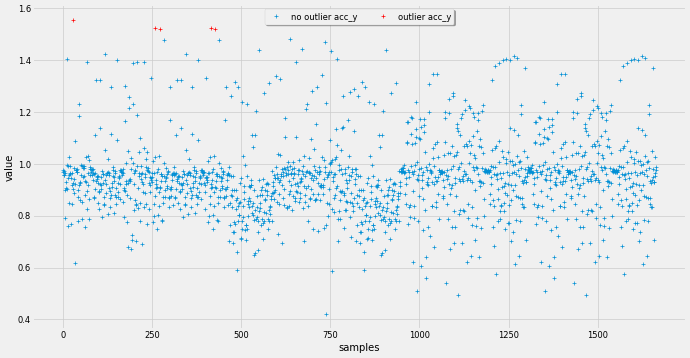

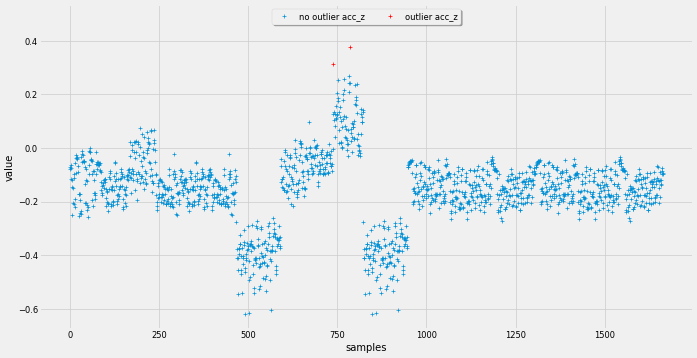

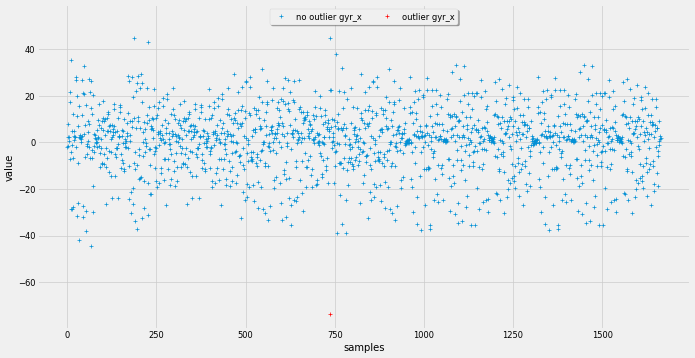

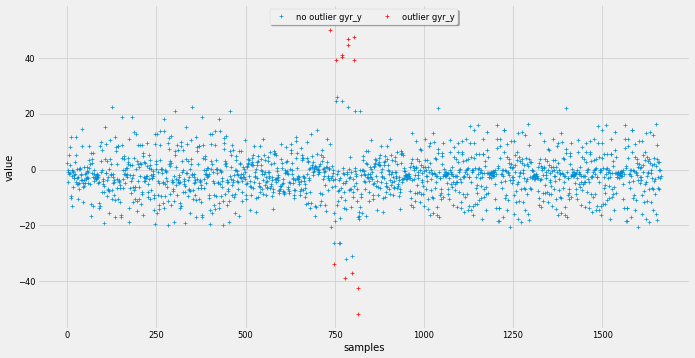

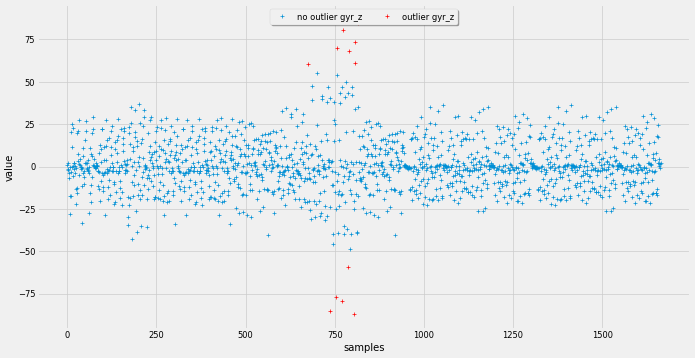

In [98]:
# Chauvenet
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col + "_outlier", True)

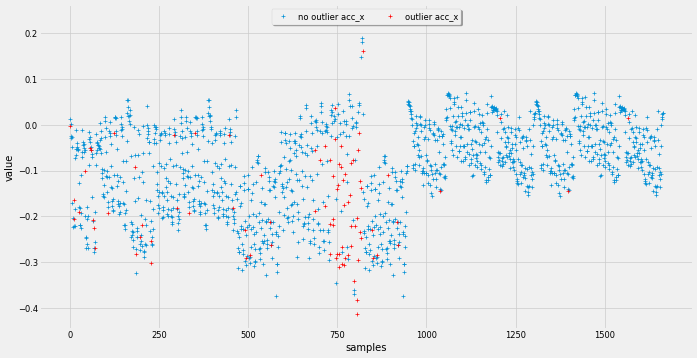

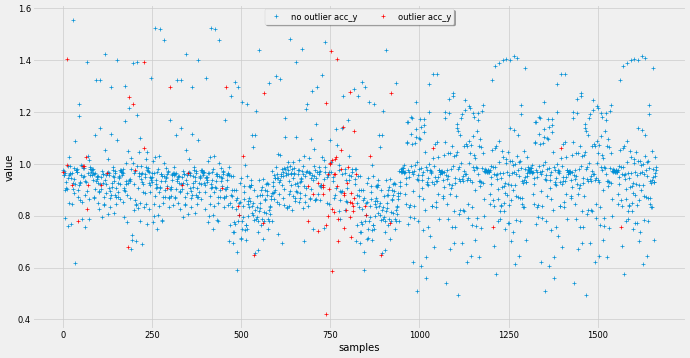

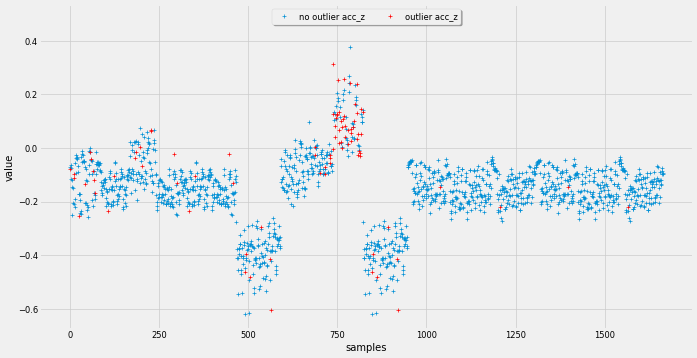

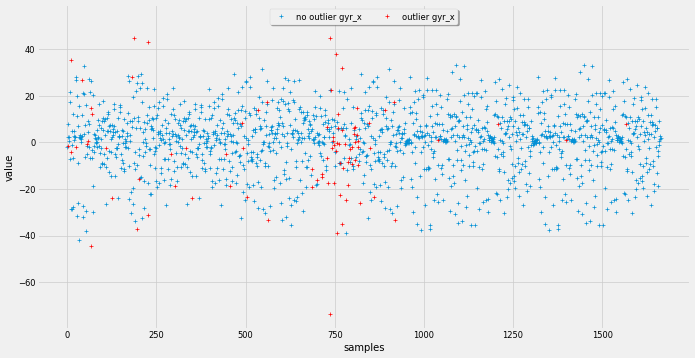

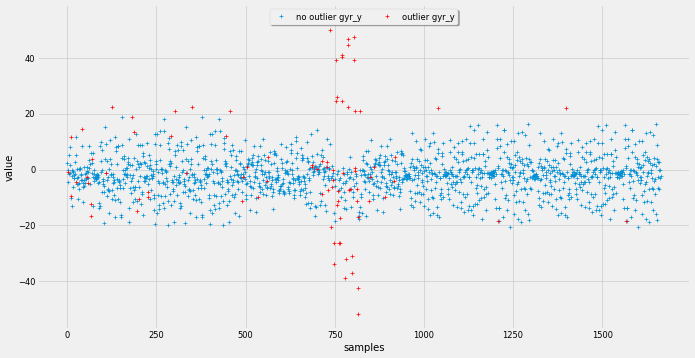

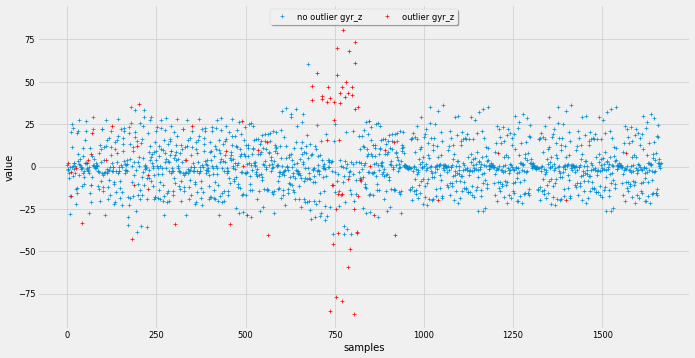

In [99]:
# Local Outlier Factor
dataset, outliers, X_scores = mark_outliers_lof(
    df[df["label"] == label], outlier_columns
)
for col in outlier_columns:
    plot_binary_outliers(dataset, col, "outlier_lof", True)

In [100]:
# --------------------------------------------------------------
# Choose method and deal with outliers (Chauvenet)
# --------------------------------------------------------------

# Test on single column
col = "gyr_y"
dataset = mark_outliers_chauvenet(df, col)
print(f'Dataset shape before deleting ouliers: {dataset.shape}')

Dataset shape before deleting ouliers: (8180, 11)


In [101]:
# Number of outliers in the 'gyr_y' feature
print(f"Number of outliers in the gyr_y feature: {dataset['gyr_y_outlier'].sum()}")

Number of outliers in the gyr_y feature: 99


In [102]:
# Deleting the outliers just in 'gyr_y' column
dataset.loc[dataset["gyr_y_outlier"], "gyr_y"] = np.nan # Add nan value in each outlier
dataset.isna().sum()


acc_x             0
acc_y             0
acc_z             0
gyr_x             0
gyr_y            99
gyr_z             0
participant       0
label             0
category          0
set               0
gyr_y_outlier     0
dtype: int64

In [103]:
# Create a loop
outliers_removes_df = df.copy()
for col in outlier_columns:
    for label in df["label"].unique():
        dataset = mark_outliers_chauvenet(df[df["label"] == label], col)
        # Replace values marked as outliers with NaN
        dataset.loc[dataset[col + "_outlier"], col] = np.nan
        # Updating the columns in the original dataframe
        outliers_removes_df.loc[outliers_removes_df["label"] == label, col] = dataset[
            col
        ]
        # Count the number of outliers
        n_outliers = len(dataset) - len(dataset[col].dropna())
        print(f"Removed {n_outliers} outliers from {col} for label {label}")

Removed 0 outliers from acc_x for label bench
Removed 2 outliers from acc_x for label ohp
Removed 0 outliers from acc_x for label squat
Removed 2 outliers from acc_x for label dead
Removed 1 outliers from acc_x for label row
Removed 2 outliers from acc_x for label rest
Removed 5 outliers from acc_y for label bench
Removed 6 outliers from acc_y for label ohp
Removed 0 outliers from acc_y for label squat
Removed 0 outliers from acc_y for label dead
Removed 1 outliers from acc_y for label row
Removed 0 outliers from acc_y for label rest
Removed 3 outliers from acc_z for label bench
Removed 6 outliers from acc_z for label ohp
Removed 0 outliers from acc_z for label squat
Removed 1 outliers from acc_z for label dead
Removed 0 outliers from acc_z for label row
Removed 0 outliers from acc_z for label rest
Removed 2 outliers from gyr_x for label bench
Removed 4 outliers from gyr_x for label ohp
Removed 1 outliers from gyr_x for label squat
Removed 6 outliers from gyr_x for label dead
Removed 0

In [104]:
# Outliers removed for each column
outliers_removes_df.isna().sum()

acc_x           7
acc_y          12
acc_z          10
gyr_x          25
gyr_y          64
gyr_z          62
participant     0
label           0
category        0
set             0
dtype: int64

In [105]:
# Dataframe shape after deleting outliers
outliers_removes_df.shape

(8180, 10)

**Códigos orignais:** `../src/data/remove_outliers.py`

**Arquivo salvo em:** `../data/interim/02_outliers_removes_chauvenet.pkl"`

**Próxima etapa:** `04_build_features.ipynb`